# Conteúdo dos arquivos NWB

Este dataset contém gravações eletrofisiológicas no **córtex entorrinal (LEC, MEC)** e no **hipocampo (CA1)** de ratos Long Evans adultos, coletadas com sondas Neuropixels 2.0 em condições de livre comportamento.

---

## Estrutura dos Arquivos

Cada arquivo `.nwb` segue o padrão **NWB 2.0 (HDF5)** e inclui:

- **/epochs**  
  Blocos de tempo correspondentes a tarefas ou estados (ex.: *Foraging task*, *Natural sleep*, *Figure-eight*, *Odor sequence*, *Novel object*).  

- **/units**  
  Informações de cada unidade neuronal isolada após spike sorting (spike times, taxas médias, metadados de qualidade).  

- **/processing/behavior/position**  
  Trajetória do animal no plano 2D (x, y).  

- **/processing/behavior/direction**  
  Direção da cabeça do animal.  

- **/processing/behavior/speed**  
  Velocidade de deslocamento em cm/s.  

- **/time_intervals/**  
  Eventos específicos em tarefas de sequência:  
  - `mill_active` → quando a esteira estava ligada.  
  - `door_open` → quando a porta do labirinto foi aberta.  

- **/acquisition/**  
  Sinais eletrofisiológicos brutos (30 kHz), não utilizados diretamente nas tabelas derivadas.  

---

## Metadados Importantes

- **Subject ID**: identifica cada rato (9 sujeitos no total).  
- **session_description**: breve descrição do experimento.  
- **start_time / stop_time**: duração da sessão.  
- **task**: tipo de comportamento associado àquele bloco de gravação.  

---

## Tipos de Sessão

De acordo com o índice (`index.json`), os arquivos incluem registros de:

1. **Foraging task** – exploração em arena aberta em busca de comida.  
2. **Figure-eight task** – corrida em labirinto em forma de 8 com recompensa.  
3. **Odor sequence task** – tarefa de sequência de odores em esteira + recompensa.  
4. **Novel object task** – exploração de objetos novos em arena.  
5. **Natural sleep** – períodos de sono natural em caixa de descanso.  

---

## Uso dos Dados

A partir desses arquivos, é possível extrair:

- **Atividade neural (spike times, firing rates)** por unidade ou população.  
- **Comportamento** (posição, direção, velocidade, imobilidade).  
- **Estrutura temporal de eventos** durante cada tarefa.  

Os CSVs derivados organizam essa informação em **bins temporais** (ex.: 10 ms), unificando sinais neurais e variáveis comportamentais para análises de dinâmica populacional e replay.  

## Funções usadas para extrair o conteúdo

### Fluxo de Trabalho de Extração e Consolidação de Dados NWB (Neurodata Without Borders)

O processo foi dividido em duas fases principais, executadas por dois scripts Python:

- **`nwb_cru.py` (Extração):** Script responsável por acessar diretamente os dados crus armazenados no arquivo NWB e exportá-los para arquivos CSV individuais.  
- **`nwb_consolidate.py` (Consolidação):** Script que organiza, agrupa e combina os arquivos CSV individuais gerados pela fase de extração em arquivos maiores e padronizados.

---

## 1. Extração Crua (`nwb_cru.py`)

O script `nwb_cru.py` é a porta de entrada para os dados brutos. Ele segue o princípio da **Extração Crua**, ou seja, os dados são retirados do NWB no formato mais próximo do original, sem binning, médias ou transformações complexas.

### Conceitos Principais

| Conceito                         | O que é |
|----------------------------------|---------|
| **NWB (Neurodata Without Borders)** | Um **formato de arquivo padronizado** (baseado em HDF5) para armazenar dados de neurociência experimental, como eletrofisiologia, comportamento e imagem. |
| **pynwb**                        | Uma **biblioteca Python** que permite **ler e escrever arquivos NWB**, fornecendo acesso estruturado e padronizado aos dados. |
| **Leitura Preguiçosa (Lazy Loading)** | Um **método de carregamento sob demanda**. Em vez de trazer todos os dados (como milhões de spikes) para a memória de uma só vez, carrega apenas referências e lê dados em partes menores. Isso economiza memória RAM. |
| **units Table**                  | Uma **tabela interna do NWB** que armazena informações sobre cada unidade registrada (exemplo: ID, localização, eletrodo associado). |
| **Time Series / Spatial Series** | Estruturas no NWB para **armazenar dados contínuos no tempo**, com carimbo de tempo (timestamp). Exemplos: posição do animal ou velocidade de movimento. |

### Exportar para Planilhas

O script percorre cada arquivo NWB e gera os seguintes arquivos CSV ou JSON:

| Categoria de Dados  | Função de Extração             | Arquivo de Saída | O que é |
|---------------------|--------------------------------|------------------|---------|
| **Metadados**       | `get_session_meta`             | `[sessão]_metadata.json` | Informações gerais da sessão, como data, animal, equipamento, etc. |
| **Unidades / Células** | `get_units_table`           | `[sessão]_units.csv` | Lista de células/unidades registradas com seus atributos. |
| **Spike Times**     | `save_spike_times_to_csv`      | `[sessão]_spike_times.csv` | Registro dos instantes de disparo de cada célula. |
| **Épocas / Intervalos** | `get_epochs_df`, `get_time_intervals` | `[sessão]_epochs.csv`, `[sessão]_intervals_[nome].csv` | Períodos de interesse do experimento, como fases de estímulo ou repouso. |
| **Comportamento**   | `get_behavior_time_series`     | `[sessão]_[nome_serie].csv` | Dados contínuos relacionados ao comportamento, como posição ou velocidade. |

**Destaque:**  
A função `save_spike_times_to_csv` utiliza `get_spike_handles` e `iter_unit_spike_slices` para ler os *spike times* de forma eficiente, gerando um DataFrame final com colunas **unit_id** (identificador da célula) e **spike_time** (instante de disparo).

---

## 2. Consolidação de Dados (`nwb_consolidate.py`)

O script `nwb_consolidate.py` organiza e padroniza os arquivos CSV gerados na etapa anterior, criando conjuntos consolidados de dados para análise.

### Conceitos Principais

| Conceito | O que é |
|----------|---------|
| **Agrupamento por Mapeamento (CSV_MAPPING)** | Um **dicionário de configuração** que define como diferentes CSVs devem ser agrupados. Exemplo: arquivos de velocidade (`movement_speed.csv`, `head_yaw_speed.csv`) são combinados em um só (`consolidated_behavior_speed.csv`). |
| **Concatenação de DataFrames (pd.concat)** | Uma **operação da biblioteca Pandas** que empilha DataFrames linha a linha, unindo vários arquivos em um só. |
| **Colunas de Identificação (source_file)** | Uma **coluna adicional** que registra de qual sessão/arquivo NWB cada linha de dado veio. Isso garante rastreabilidade mesmo após a consolidação. |

### Fluxo de Funcionamento

1. **Configuração**  
   - Define as pastas de entrada (`INPUT_DIR`) e saída (`OUTPUT_DIR`).

2. **Iteração**  
   - Percorre todos os arquivos CSV presentes em `INPUT_DIR`.

3. **Identificação do Grupo**  
   - Para cada CSV, utiliza `CSV_MAPPING` e `find_csv_group` para determinar em qual arquivo consolidado ele será incluído.

4. **Injeção de Metadados**  
   - Lê o CSV em um DataFrame (`pd.read_csv`).  
   - Extrai o nome da sessão (exemplo: `27963_2022-Feb-09_08-02-57`).  
   - Adiciona a coluna `source_file` ao DataFrame para indicar a origem.  
   - Adiciona o DataFrame à lista do grupo correspondente.

5. **Agrupamento Final**  
   - Usa `pd.concat()` para unir todos os DataFrames de um grupo.  
   - Salva o resultado em um novo arquivo consolidado na `OUTPUT_DIR`.

---


# Buscando Dados

In [47]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install ydata-profiling

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------ --------------------- 1.3/2.8 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.8/30.3 MB 8.4 MB/s eta 0:00:04
   ----- ---------------------------------- 4.2/30.3 MB 9.7 MB/s eta 0:00:03
   ------- -------------------------------- 5.5/30.3 MB 7.8 MB/s eta 0:00:04
   -------- ------------------------------- 6.3/30.3 MB 8.0 MB/s eta 0:00:03
   -------- ------------------------------- 6.3/30.3 MB 8.0 MB/s eta 0:00:03
   -------- ------------------------------- 6.3/30.3 MB 8.0 MB/s eta 0:00:03
   -------- ------------------------------- 6.3/30.3 MB 8.0 MB/s eta 0:00:03
   -------- ------------------------------- 6.3/30.3 MB 8.0 MB/s eta 0:00:03
   --------- ------------------------------ 7.3/30.3 MB 3.8 MB/s eta 0:00:07
   --------- ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-airflow-providers-sqlite 4.0.0 requires apache-airflow>=2.9.0, which is not installed.
tensorflow-intel 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# # Puxa o csv
# df_behavior_position = pd.read_csv("/content/drive/MyDrive/replay_curve/outputs_replay_sleep/consolidated_behavior_position.csv", low_memory=False)
# df_behavior_speed = pd.read_csv("/content/drive/MyDrive/replay_curve/outputs_replay_sleep/consolidated_behavior_speed.csv", low_memory=False)
# df_epochs = pd.read_csv("/content/drive/MyDrive/replay_curve/outputs_replay_sleep/consolidated_epochs.csv", low_memory=False)
# df_units = pd.read_csv("/content/drive/MyDrive/replay_curve/outputs_replay_sleep/consolidated_units.csv", low_memory=False)
# df_spike_times = pd.read_csv("/content/drive/MyDrive/replay_curve/outputs_replay_sleep/consolidated_spike_times.csv", low_memory=False)



In [23]:
# Lendo os CSVs
df_behavior_position = pd.read_csv(
    "outputs_replay_sleep/consolidated_behavior_position.csv",
    low_memory=False
)

df_behavior_speed = pd.read_csv(
    "outputs_replay_sleep/consolidated_behavior_speed.csv",
    low_memory=False
)

df_epochs = pd.read_csv(
    "outputs_replay_sleep/consolidated_epochs.csv",
    low_memory=False
)

df_units = pd.read_csv(
    "outputs_replay_sleep/consolidated_units.csv",
    low_memory=False
)

df_spike_times = pd.read_csv(
    "outputs_replay_sleep/consolidated_spike_times.csv",
    low_memory=False
)

In [24]:
print(df_behavior_position.shape)
print(df_behavior_speed.shape)
print(df_epochs.shape)
print(df_units.shape)
print(df_spike_times.shape)

(14472702, 6)
(14472702, 4)
(7, 9)
(15155, 8)
(15155, 3)


In [25]:
print(df_behavior_position.columns)
print(df_behavior_speed.columns)
print(df_epochs.columns)
print(df_units.columns)
print(df_spike_times.columns)

Index(['source_file', 'timestamp', 'animal_position_data_dim0',
       'animal_position_data_dim1', 'animal_position_data_dim2',
       'head_direction_data_dim0'],
      dtype='object')
Index(['source_file', 'timestamp', 'head_yaw_speed_data',
       'movement_speed_data'],
      dtype='object')
Index(['source_file', 'id', 'start_time', 'stop_time', 'task', 'arena',
       'arena_geometry', 'arena_dimensions', 'light_level'],
      dtype='object')
Index(['source_file', 'id', 'sampling_rate', 'cluster_quality', 'spike_times',
       'electrodes', 'electrode_group', 'waveform_mean'],
      dtype='object')
Index(['source_file', 'unit_id', 'spike_time'], dtype='object')


In [26]:
df_behavior_position.head(2)

,source_file,timestamp,animal_position_data_dim0,animal_position_data_dim1,animal_position_data_dim2,head_direction_data_dim0
0,27284_2021-Jun-16_08-24-12,74.002446,-33.746044,-20.55085,-3.512803,NaN
1,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.60195,-3.475338,NaN


In [27]:
df_behavior_speed.head(2)


,source_file,timestamp,head_yaw_speed_data,movement_speed_data
0,27284_2021-Jun-16_08-24-12,74.002446,NaN,NaN
1,27284_2021-Jun-16_08-24-12,74.010688,NaN,NaN


In [28]:
df_epochs.head(2)

,source_file,id,start_time,stop_time,task,arena,arena_geometry,arena_dimensions,light_level
0,27284_2021-Jun-16_08-24-12,0,74.0,9974.0,Natural sleep,sleep_box,square,[40. 40. 80.],bright
1,27963_2022-Feb-09_08-02-57,0,67.0,6417.0,Natural sleep,sleep_box,square,[40. 40. 80.],bright


In [29]:
df_units.head(2)

,source_file,id,sampling_rate,cluster_quality,spike_times,electrodes,electrode_group,waveform_mean
0,27284_2021-Jun-16_08-24-12,0,30000.0,mua,[ 74.009 74.02566667 74.09686667 ......,"Empty DataFrame\nColumns: [location, group, gr...",probe_1 - 0-95; 1280-1375; 2560-2655; 3840-393...,[nan nan nan nan nan nan nan nan nan nan nan n...
1,27284_2021-Jun-16_08-24-12,1,30000.0,mua,[ 75.9183 75.98246667 76.36596667 ......,"Empty DataFrame\nColumns: [location, group, gr...",probe_1 - 0-95; 1280-1375; 2560-2655; 3840-393...,[nan nan nan nan nan nan nan nan nan nan nan n...


In [30]:
df_spike_times.head(2)

,source_file,unit_id,spike_time
0,27284_2021-Jun-16_08-24-12,0,28817
1,27284_2021-Jun-16_08-24-12,0,52973


### Documentação dos DataFrames

#### 1. `df_behavior_position`
Colunas:
- **source_file** → Nome do arquivo `.nwb` de onde os dados foram extraídos. Identifica a sessão/animal.
- **timestamp** → Tempo em segundos da gravação, alinhado entre posição e atividade neural.
- **animal_position_data_dim0** → Coordenada *x* (horizontal) da posição do animal na arena.
- **animal_position_data_dim1** → Coordenada *y* (vertical) da posição do animal.
- **animal_position_data_dim2** → Coordenada *z* (altura). No estudo normalmente projetada em 2D, mas ainda registrada.
- **head_direction_data_dim0** → Direção da cabeça do animal (em graus ou radianos), estimada a partir do tracking dos marcadores.

Este DataFrame descreve **trajetória e orientação da cabeça** do animal no espaço físico durante a sessão.

---

#### 2. `df_behavior_speed`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **timestamp** → Tempo em segundos.
- **head_yaw_speed_data** → Velocidade angular da cabeça (variação na direção da cabeça).
- **movement_speed_data** → Velocidade linear de deslocamento do animal (cm/s).

Este DataFrame mostra **como o animal se move**: tanto a translação (andar/correr) quanto a rotação da cabeça. (não será usado)

---

#### 3. `df_epochs`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **id** → Identificador único de cada epoch dentro do arquivo.
- **start_time** → Tempo inicial do epoch (s).
- **stop_time** → Tempo final do epoch (s).
- **task** → Tipo de tarefa ou condição comportamental (ex.: *Foraging task*, *Natural sleep*, *Odor sequence task*, *Novel object task*).
- **arena** → Identificação da arena experimental.
- **arena_geometry** → Forma geométrica da arena (ex.: quadrada, circular, figura-8).
- **arena_dimensions** → Dimensões da arena (ex.: 1m x 1m).
- **light_level** → Condição de iluminação (ex.: luz fraca, normal, escuro).

Este DataFrame descreve **as sessões experimentais** (períodos de sono, exploração, tarefas específicas).

---

#### 4. `df_units`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **id** → Identificador do cluster de spikes (neurônio isolado).
- **sampling_rate** → Taxa de amostragem usada na gravação desse cluster.
- **cluster_quality** → Qualidade da clusterização do spike (ex.: *good*, *mua* [multi-unit activity]).
- **spike_times** → Lista de tempos (s) em que os spikes desse neurônio ocorreram.
- **electrodes** → Número(s) de eletrodo(s) que captaram essa unidade.
- **electrode_group** → Grupo de eletrodos (ex.: qual região do probe Neuropixels).
- **waveform_mean** → Forma de onda média do spike, útil para classificação e validação da unidade.

Este DataFrame representa **metadados das unidades neuronais isoladas**.

---

#### 5. `df_spike_times`
Colunas:
- **source_file** → Arquivo `.nwb` de origem.
- **unit_id** → Identificador do neurônio (corresponde ao `id` de `df_units`).
- **spike_time** → Tempo (s) em que ocorreu um spike dessa unidade.

Este DataFrame é a versão **longa** dos spikes: cada linha corresponde a um **único disparo neural**.

---

Em resumo:  
- `df_behavior_position` e `df_behavior_speed` → comportamento (trajetória, velocidade, orientação).  
- `df_epochs` → contexto experimental (sono, tarefas).  
- `df_units` e `df_spike_times` → atividade neuronal (quais neurônios, quando dispararam, em quais condições).  


# Preparando Dados

## Behavior Position

In [31]:
use_cols = [
    "source_file", "timestamp",
    "animal_position_data_dim0", "animal_position_data_dim1"
]
df_pos = df_behavior_position[use_cols]
df_pos = df_pos.rename(columns={
    "animal_position_data_dim0": "x",
    "animal_position_data_dim1": "y"
})
df_pos.head(2)

,source_file,timestamp,x,y
0,27284_2021-Jun-16_08-24-12,74.002446,-33.746044,-20.55085
1,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.60195


In [32]:
# mostra correlação entre colunas numericas
df_pos.select_dtypes(include=np.number).corr()

,timestamp,x,y
timestamp,1.000000,-0.216800,-0.087193
x,-0.216800,1.000000,-0.005774
y,-0.087193,-0.005774,1.000000


carregamos o CSV bruto e ficamos só com tempo (timestamp) e posição XY (x, y). também guardamos source_file para sabermos de qual sessão veio cada linha.

In [33]:
# garante tipos corretos
df_pos["timestamp"] = pd.to_numeric(df_pos["timestamp"], errors="coerce")
df_pos["x"] = pd.to_numeric(df_pos["x"], errors="coerce")
df_pos["y"] = pd.to_numeric(df_pos["y"], errors="coerce")

# remove linhas sem x/y/timestamp
df_pos = df_pos.dropna(subset=["timestamp", "x", "y"]).copy()

# ordena por sessão e tempo
df_pos = df_pos.sort_values(["source_file", "timestamp"]).reset_index(drop=True)

# remove duplicatas exatas (se houver)
df_pos = df_pos.drop_duplicates(subset=["source_file", "timestamp", "x", "y"]).reset_index(drop=True)

df_pos.head(3)


,source_file,timestamp,x,y
0,27284_2021-Jun-16_08-24-12,74.002446,-33.746044,-20.55085
1,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.60195
2,27284_2021-Jun-16_08-24-12,74.018948,-33.665432,-20.68427


consertamos tipos numéricos, tiramos linhas vazias, ordenamos por tempo e removemos duplicatas. isso evita erros na hora de derivar velocidade.

In [34]:
df_pos["dx"] = df_pos.groupby("source_file")["x"].diff().fillna(0)
df_pos["dy"] = df_pos.groupby("source_file")["y"].diff().fillna(0)
df_pos["dt"] = df_pos.groupby("source_file")["timestamp"].diff().fillna(0)
df_pos["speed_units_per_s"] = np.sqrt((df_pos["dx"]**2 + df_pos["dy"]**2) / df_pos["dt"]).fillna(0)

df_pos.head(3)

,source_file,timestamp,x,y,dx,dy,dt,speed_units_per_s
0,27284_2021-Jun-16_08-24-12,74.002446,-33.746044,-20.55085,0.000000,0.00000,0.000000,0.000000
1,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.60195,0.023369,-0.05110,0.008242,0.618930
2,27284_2021-Jun-16_08-24-12,74.018948,-33.665432,-20.68427,0.057243,-0.08232,0.008260,1.103248


Para cada sessão (source_file):
- dx = x[t] - x[t-1]
- dy = y[t] - y[t-1]

- Distância = sqrt(dx²+dy²).
- Velocidade ≈ distância / diferença de tempo (dt).

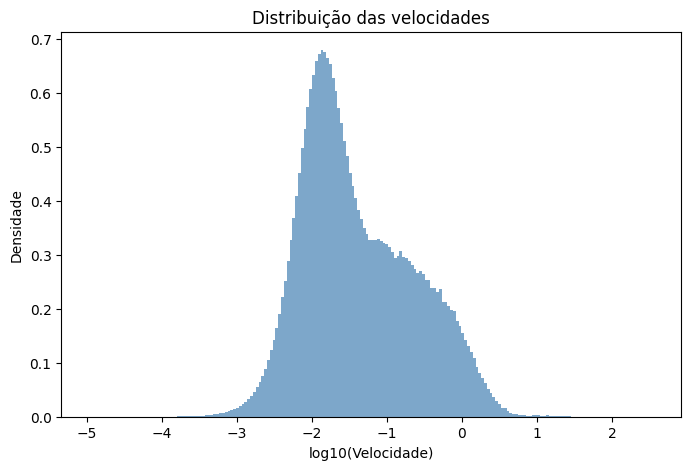

In [35]:
# Preparar os dados: tirar NaNs e infinitos
speed = df_pos["speed_units_per_s"].dropna()
speed = speed[speed > 0]   # ignora zeros artificiais

# Usa log pois a distribuição é muito distorcida
use_log = True
data = np.log10(speed) if use_log else speed

# 3. Plotar histograma
plt.figure(figsize=(8,5))
plt.hist(data, bins=200, density=True, alpha=0.7, color="steelblue")
plt.xlabel("log10(Velocidade)" if use_log else "Velocidade (units/s)")
plt.ylabel("Densidade")
plt.title("Distribuição das velocidades")
plt.show()


Vale entre os dois picos está em torno de **-1.3 a -1.0 em log₁₀**, ou seja:

- \(10^{-1.3} \approx 0.05\)  
- \(10^{-1.0} = 0.1\)

Então um bom **limiar inicial** para dizer se esta ou não imovel seria algo como **0.05 ou 0.07 units/s**.


In [36]:
IMMOBILE_THRESHOLD = 0.5
df_pos["is_immobile"] = (df_pos["speed_units_per_s"] <= IMMOBILE_THRESHOLD).astype(int)
df_pos.head(3)


,source_file,timestamp,x,y,dx,dy,dt,speed_units_per_s,is_immobile
0,27284_2021-Jun-16_08-24-12,74.002446,-33.746044,-20.55085,0.000000,0.00000,0.000000,0.000000,1
1,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.60195,0.023369,-0.05110,0.008242,0.618930,0
2,27284_2021-Jun-16_08-24-12,74.018948,-33.665432,-20.68427,0.057243,-0.08232,0.008260,1.103248,0


In [37]:
# Retira o primeiro segundo de cada source file
df_pos = df_pos.groupby("source_file").apply(lambda x: x.iloc[1:]).reset_index(drop=True)
df_pos.head(3)

,source_file,timestamp,x,y,dx,dy,dt,speed_units_per_s,is_immobile
0,27284_2021-Jun-16_08-24-12,74.010688,-33.722675,-20.601950,0.023369,-0.051100,0.008242,0.618930,0
1,27284_2021-Jun-16_08-24-12,74.018948,-33.665432,-20.684270,0.057243,-0.082320,0.008260,1.103248,0
2,27284_2021-Jun-16_08-24-12,74.027236,-33.604760,-20.739647,0.060672,-0.055377,0.008288,0.902313,0


In [38]:
def bin_immobility(
    df,
    bin_size_s=0.010,
    min_samples_per_bin=1,
    immobile_rule="majority"
):

    need_cols = {"source_file","timestamp","is_immobile"}
    if not need_cols.issubset(df.columns):
        raise ValueError(f"df precisa conter colunas {need_cols}")

    has_speed = "speed_units_per_s" in df.columns
    out = []

    # garante ordenação
    df = df.sort_values(["source_file","timestamp"]).copy()

    for sid, g in df.groupby("source_file", group_keys=False):
        tmin, tmax = g["timestamp"].min(), g["timestamp"].max()
        edges = np.arange(tmin, tmax + bin_size_s, bin_size_s)
        if len(edges) < 2:
            continue

        # index do bin de cada amostra
        idx = np.searchsorted(edges, g["timestamp"].to_numpy(), side="right") - 1
        valid = (idx >= 0) & (idx < len(edges)-1)
        gv = g.loc[valid].copy()
        gv["bin_idx"] = idx[valid]

        # agrega por bin
        grp = gv.groupby("bin_idx")
        n_in_bin = grp["is_immobile"].size().reindex(range(len(edges)-1), fill_value=0)

        # velocidade média por bin
        speed_bin = (grp["speed_units_per_s"].mean()
                         .reindex(range(len(edges)-1), fill_value=np.nan)).to_numpy()

        # proporção de imobilidade no bin
        p_immobile = (grp["is_immobile"].mean()
                      .reindex(range(len(edges)-1), fill_value=np.nan)).to_numpy()

        # se na maioria ele ta movel ou imovel
        immobile_bin = (p_immobile >= 0.5).astype(float)
        immobile_bin[np.isnan(p_immobile)] = np.nan  # sem amostras → NaN

        centers = 0.5*(edges[:-1] + edges[1:])
        out.append(pd.DataFrame({
            "source_file": sid,
            "bin_start_s": edges[:-1],
            "bin_end_s": edges[1:],
            "bin_center_s": centers,
            "speed_units_per_s": speed_bin,
            "is_immobile": immobile_bin,
            "n_samples_in_bin": n_in_bin.to_numpy()
        }))

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

In [39]:
df_bins_pos = bin_immobility(df_pos, bin_size_s=0.010, immobile_rule="majority")
df_bins_pos.head()

,source_file,bin_start_s,bin_end_s,bin_center_s,speed_units_per_s,is_immobile,n_samples_in_bin
0,27284_2021-Jun-16_08-24-12,74.010688,74.020688,74.015688,0.861089,0.0,2
1,27284_2021-Jun-16_08-24-12,74.020688,74.030688,74.025688,0.902313,0.0,1
2,27284_2021-Jun-16_08-24-12,74.030688,74.040688,74.035688,0.979128,0.0,1
3,27284_2021-Jun-16_08-24-12,74.040688,74.050688,74.045688,1.103128,0.0,1
4,27284_2021-Jun-16_08-24-12,74.050688,74.060688,74.055688,1.060987,0.0,2


Dividimos o tempo em janelas (bins) de tamanho fixo e, para cada arquivo (source_file), calcula dentro de cada janela: quantas amostras caíram ali, a velocidade média e se o animal foi considerado imóvel ou não (pela regra da maioria dos pontos nesse intervalo). No final, ela retorna um DataFrame organizado por bins, com início, fim, centro, média de velocidade, status de imobilidade e número de amostras em cada bin.

 O tamanho do bin (~10 ms) é escolhido porque eventos como replay e ripples duram apenas algumas dezenas de milissegundos — assim, essa resolução é suficiente para capturar essas dinâmicas rápidas sem tornar os dados esparsos demais.

## Epochs + Units

In [40]:
df_units["cluster_quality"].value_counts()

cluster_quality
good    7774
mua     7381
Name: count, dtype: int64

- **MUA (Multi-Unit Activity)**  
  Sigla para *Atividade Multiunidade*.  
  Representa a atividade elétrica registrada por um eletrodo que capta disparos de **vários neurônios próximos ao mesmo tempo**, sem conseguir separá-los com precisão.  
  - Serve para analisar **atividade populacional** — quando queremos saber o nível geral de disparo em uma região ou detectar eventos coletivos, como *sharp-wave ripples*.

- **Good (Single-Unit, SU)**  
  Indica que o cluster corresponde a **um neurônio isolado** com alta confiança.  
  Os spikes são consistentes e bem separados de outros neurônios.  
  - Serve para estudar **a codificação individual** dos neurônios, como *place cells* que disparam em posições específicas do ambiente.

---

Resumindo:  
- **MUA** → mistura de vários neurônios → útil para dinâmica global.  
- **Good** → um neurônio confiável → útil para análises finas de codificação.

Vamos usar os dois pois queremos saber se a população disparou muito num curto intervalo.

- mua = ajuda a detectar “quando” pode haver replay (candidatos).

- good = ajuda a entender “o que” está sendo reativado (conteúdo da trajetória).

In [41]:
# ids por classe
good_ids = df_units.loc[df_units["cluster_quality"]=="good", ["source_file","id"]].rename(columns={"id":"unit_id"})
mua_ids  = df_units.loc[df_units["cluster_quality"]=="mua",  ["source_file","id"]].rename(columns={"id":"unit_id"})

# para MUA (população): good + mua
all_ids = pd.concat([good_ids, mua_ids], ignore_index=True).drop_duplicates()
all_ids.head(3)

,source_file,unit_id
0,27284_2021-Jun-16_08-24-12,5
1,27284_2021-Jun-16_08-24-12,14
2,27284_2021-Jun-16_08-24-12,21


In [42]:
# filtra spikes por classes
spk_all  = df_spike_times.merge(all_ids,  on=["source_file","unit_id"], how="inner")     # para MUA
spk_good = df_spike_times.merge(good_ids, on=["source_file","unit_id"], how="inner")     # para per-unidade

In [43]:
spk_all.head(3)

,source_file,unit_id,spike_time
0,27284_2021-Jun-16_08-24-12,0,28817
1,27284_2021-Jun-16_08-24-12,0,52973
2,27284_2021-Jun-16_08-24-12,0,71817


In [44]:
spk_good.head(3)

,source_file,unit_id,spike_time
0,29630_2024-Sep-17_07-08-26,1,2113
1,29630_2024-Sep-17_07-08-26,1,2113
2,29630_2024-Sep-17_07-08-26,1,3355


Separamos quais unidades são good e mua; criamos dois subconjuntos de spikes: todos (good+mua) para sinal populacional, e só good para análises por neurônio.

In [53]:
import numpy as np
import pandas as pd
from math import floor, ceil

BIN_SIZE_S = 0.010  # 10 ms

def _floor_to_bin(x, bin_size):
    return bin_size * np.floor(x / bin_size)

def _build_bins_from_index(bin_idx, t0, bin_size):
    start = t0 + bin_idx * bin_size
    end   = start + bin_size
    center = start + 0.5 * bin_size
    return start, end, center

def bin_spikes_population(spk_df, bin_size_s=BIN_SIZE_S, window_size_s=None):
    """
    MUA por bin (good+mua), sem alocar bordas/edges.
    Se window_size_s for informado, processa em janelas para economizar memória.
    Retorna DF com uma linha por bin.
    """
    rows = []
    for sid, g in spk_df.groupby("source_file", group_keys=False):
        if g.empty:
            continue

        tmin = float(g["spike_time"].min())
        tmax = float(g["spike_time"].max())
        t0 = _floor_to_bin(tmin, bin_size_s)
        n_units = g["unit_id"].nunique()

        # Sem janelas: faz tudo de uma vez
        if not window_size_s:
            bin_idx = np.floor((g["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
            counts = pd.Series(1, index=bin_idx).groupby(level=0).sum()
            start, end, center = _build_bins_from_index(counts.index.to_numpy(), t0, bin_size_s)
            out = pd.DataFrame({
                "source_file": sid,
                "bin_start_s": start,
                "bin_end_s":   end,
                "bin_center_s": center,
                "bin_size_s":  bin_size_s,
                "mua_count":   counts.to_numpy(dtype=np.int32),
                "mua_rate_hz": (counts.to_numpy(dtype=np.float32) / bin_size_s),
                "n_units":     n_units
            })
            rows.append(out)
        else:
            # Em janelas (ex.: 3600 s => 1h). Útil para gravações longas/esparsas.
            w = float(window_size_s)
            # garante que cobrimos [tmin, tmax]
            n_chunks = int(ceil((tmax - tmin) / w)) if (tmax > tmin) else 1
            for k in range(n_chunks):
                a = tmin + k * w
                b = min(a + w, tmax)
                sel = g[(g["spike_time"] >= a) & (g["spike_time"] < b)]
                if sel.empty:
                    continue
                t0k = _floor_to_bin(a, bin_size_s)
                bin_idx = np.floor((sel["spike_time"].to_numpy() - t0k) / bin_size_s).astype(np.int64)
                counts = pd.Series(1, index=bin_idx).groupby(level=0).sum()
                start, end, center = _build_bins_from_index(counts.index.to_numpy(), t0k, bin_size_s)
                out = pd.DataFrame({
                    "source_file": sid,
                    "bin_start_s": start,
                    "bin_end_s":   end,
                    "bin_center_s": center,
                    "bin_size_s":  bin_size_s,
                    "mua_count":   counts.to_numpy(dtype=np.int32),
                    "mua_rate_hz": (counts.to_numpy(dtype=np.float32) / bin_size_s),
                    "n_units":     n_units
                })
                rows.append(out)

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def bin_spikes_per_unit_good(spk_df, bin_size_s=BIN_SIZE_S, window_size_s=None):
    """
    Contagem por unidade×bin (apenas good), formato longo e esparso (só bins > 0),
    sem alocar bordas/edges. Suporta janelamento opcional.
    """
    rows = []
    for sid, g in spk_df.groupby("source_file", group_keys=False):
        if g.empty:
            continue

        tmin = float(g["spike_time"].min())
        tmax = float(g["spike_time"].max())

        if not window_size_s:
            t0 = _floor_to_bin(tmin, bin_size_s)
            # índice de bin para cada spike
            bin_idx = np.floor((g["spike_time"].to_numpy() - t0) / bin_size_s).astype(np.int64)
            df_idx = pd.DataFrame({
                "unit_id": g["unit_id"].to_numpy(),
                "bin_idx": bin_idx
            })
            # conta por (unit_id, bin_idx)
            counts = df_idx.value_counts(["unit_id", "bin_idx"]).reset_index(name="count")
            start, end, center = _build_bins_from_index(counts["bin_idx"].to_numpy(), t0, bin_size_s)
            out = pd.DataFrame({
                "source_file":  sid,
                "unit_id":      counts["unit_id"].astype(int).to_numpy(),
                "bin_start_s":  start,
                "bin_end_s":    end,
                "bin_center_s": center,
                "count":        counts["count"].astype(np.int32).to_numpy()
            })
            rows.append(out)
        else:
            w = float(window_size_s)
            n_chunks = int(ceil((tmax - tmin) / w)) if (tmax > tmin) else 1
            for k in range(n_chunks):
                a = tmin + k * w
                b = min(a + w, tmax)
                sel = g[(g["spike_time"] >= a) & (g["spike_time"] < b)]
                if sel.empty:
                    continue
                t0k = _floor_to_bin(a, bin_size_s)
                bin_idx = np.floor((sel["spike_time"].to_numpy() - t0k) / bin_size_s).astype(np.int64)
                df_idx = pd.DataFrame({
                    "unit_id": sel["unit_id"].to_numpy(),
                    "bin_idx": bin_idx
                })
                counts = df_idx.value_counts(["unit_id", "bin_idx"]).reset_index(name="count")
                start, end, center = _build_bins_from_index(counts["bin_idx"].to_numpy(), t0k, bin_size_s)
                out = pd.DataFrame({
                    "source_file":  sid,
                    "unit_id":      counts["unit_id"].astype(int).to_numpy(),
                    "bin_start_s":  start,
                    "bin_end_s":    end,
                    "bin_center_s": center,
                    "count":        counts["count"].astype(np.int32).to_numpy()
                })
                rows.append(out)

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


In [54]:
df_spk_pop  = bin_spikes_population(spk_all,  BIN_SIZE_S)
df_spk_unit = bin_spikes_per_unit_good(spk_good, BIN_SIZE_S)


In [57]:
# lê o dataset inteiro (todas as partes)
print(df_spk_pop.shape)
print(df_spk_unit.shape)

(13544, 8)
(4923, 6)


- Agrega **atividade populacional** (MUA = good + mua) por janelas temporais fixas (*bins*).  
Retorna um DataFrame com **uma linha por bin**, por `source_file`.


- Conta spikes **por unidade×bin** e retorna em **formato longo e esparso** (só linhas onde `count > 0`).  
O docstring diz “(apenas good)”, mas **a função não filtra** — ela assume que **`spk_df` já veio filtrado** (ex.: somente unidades com `cluster_quality == 'good'`).

Obs: guarda só bins onde houve spike
